# Imports 

## Application-specific imports 

In [1]:
import sys

In [2]:
sys.path.append("../config/")
import config

In [3]:
sys.path.append("../metaflow/")
import preprocess_fn

## General 

In [4]:
import pickle
import itertools

In [5]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing

In [6]:
import pyspark
import pyspark.sql.functions as fn
import pyspark.sql.types as t
from pyspark.ml import Pipeline
from pyspark.ml.feature import (Normalizer, Tokenizer, HashingTF, IDF)
from pyspark.mllib.linalg.distributed import (IndexedRow, IndexedRowMatrix)

# Load data from parquet

In [7]:
df = spark.read.parquet(f'{config.ARTIFACTS}/dataset/M20_cards.parquet')

# Preprocess 

In [8]:
df_filtered = df

## Fill in NA 

In [9]:
df_filtered = df_filtered.na.fill(value="", subset=["filteredText"])

## NLP with Spark

In [10]:
tokenizer = Tokenizer(inputCol="filteredText", outputCol="words")
wordsData = tokenizer.transform(df_filtered)

In [11]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=100)
featurizedData = hashingTF.transform(wordsData)

In [12]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)

In [13]:
rescaledData = idfModel.transform(featurizedData)

In [14]:
rescaledData.select("number", "name", "features").show()

+------+--------------------+--------------------+
|number|                name|            features|
+------+--------------------+--------------------+
|   127|Chandra, Awakened...|(100,[0,9,10,18,1...|
|   125|   Cavalier of Flame|(100,[10,12,13,19...|
|   167|  Cavalier of Thorns|(100,[5,8,10,12,1...|
|   216|Omnath, Locus of ...|(100,[2,5,8,10,11...|
|   210|Kaalia, Zenith Se...|(100,[5,8,10,13,1...|
|   315|       Coral Merfolk|(100,[72],[1.9924...|
|   151|  Mask of Immolation|(100,[19,23,25,26...|
|    10|    Cavalier of Dawn|(100,[1,4,10,15,1...|
|   204|  Wolfrider's Saddle|(100,[0,10,11,23,...|
|   217|          Risen Reef|(100,[5,10,13,18,...|
|    46| Atemsis, All-Seeing|(100,[8,10,13,23,...|
|   187|Overgrowth Elemental|(100,[8,11,18,25,...|
|   165|      Barkhide Troll|(100,[4,5,8,10,11...|
|   200|     Voracious Hydra|(100,[0,4,5,6,10,...|
|   104|   Gruesome Scourger|(100,[2,10,23,25,...|
|   229|    Icon of Ancestry|(100,[5,6,8,10,11...|
|   244|       Cryptic Caves|(1

In [16]:
pd_number_names = rescaledData.select("number", "name").toPandas()

In [17]:
rescaledData = rescaledData.select("number", "features")

In [20]:
pd_rescaledData = rescaledData.select("features").toPandas()

In [37]:
len(pd_rescaledData)

329

In [38]:
dense_features = np.zeros((329, 100))

In [48]:
for i in range(329):
    dense_vect = pd_rescaledData['features'][i].toArray()
    dense_features[i, :] = dense_vect

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

In [73]:
cos_similarity = cosine_similarity(dense_features)

In [74]:
cos_similarity = np.corrcoef(dense_features)

In [ ]:
# normalizer = Normalizer(inputCol="features", outputCol="normed_features")
# data = normalizer.transform(rescaledData)

In [ ]:
# mat = IndexedRowMatrix(data.select("number", "normed_features").rdd.map(lambda row: IndexedRow(row.number, row.normed_features.toArray()))).toBlockMatrix()

In [ ]:
# dot = mat.multiply(mat.transpose())

In [ ]:
# dot.numCols(), dot.numRows()

In [ ]:
# cos_similarity = dot.toLocalMatrix().toArray()

In [75]:
cos_similarity

array([[ 1.        ,  0.26598277,  0.01342657, ..., -0.06268113,
        -0.06268113, -0.06268113],
       [ 0.26598277,  1.        ,  0.25565121, ..., -0.06298385,
        -0.06298385, -0.06298385],
       [ 0.01342657,  0.25565121,  1.        , ..., -0.06217156,
        -0.06217156, -0.06217156],
       ...,
       [-0.06268113, -0.06298385, -0.06217156, ...,  1.        ,
         1.        ,  1.        ],
       [-0.06268113, -0.06298385, -0.06217156, ...,  1.        ,
         1.        ,  1.        ],
       [-0.06268113, -0.06298385, -0.06217156, ...,  1.        ,
         1.        ,  1.        ]])

In [76]:
len(pd_number_names)

329

In [77]:
names_lens = pd_number_names['name'].apply(func=len)

In [78]:
import matplotlib.pyplot as plt

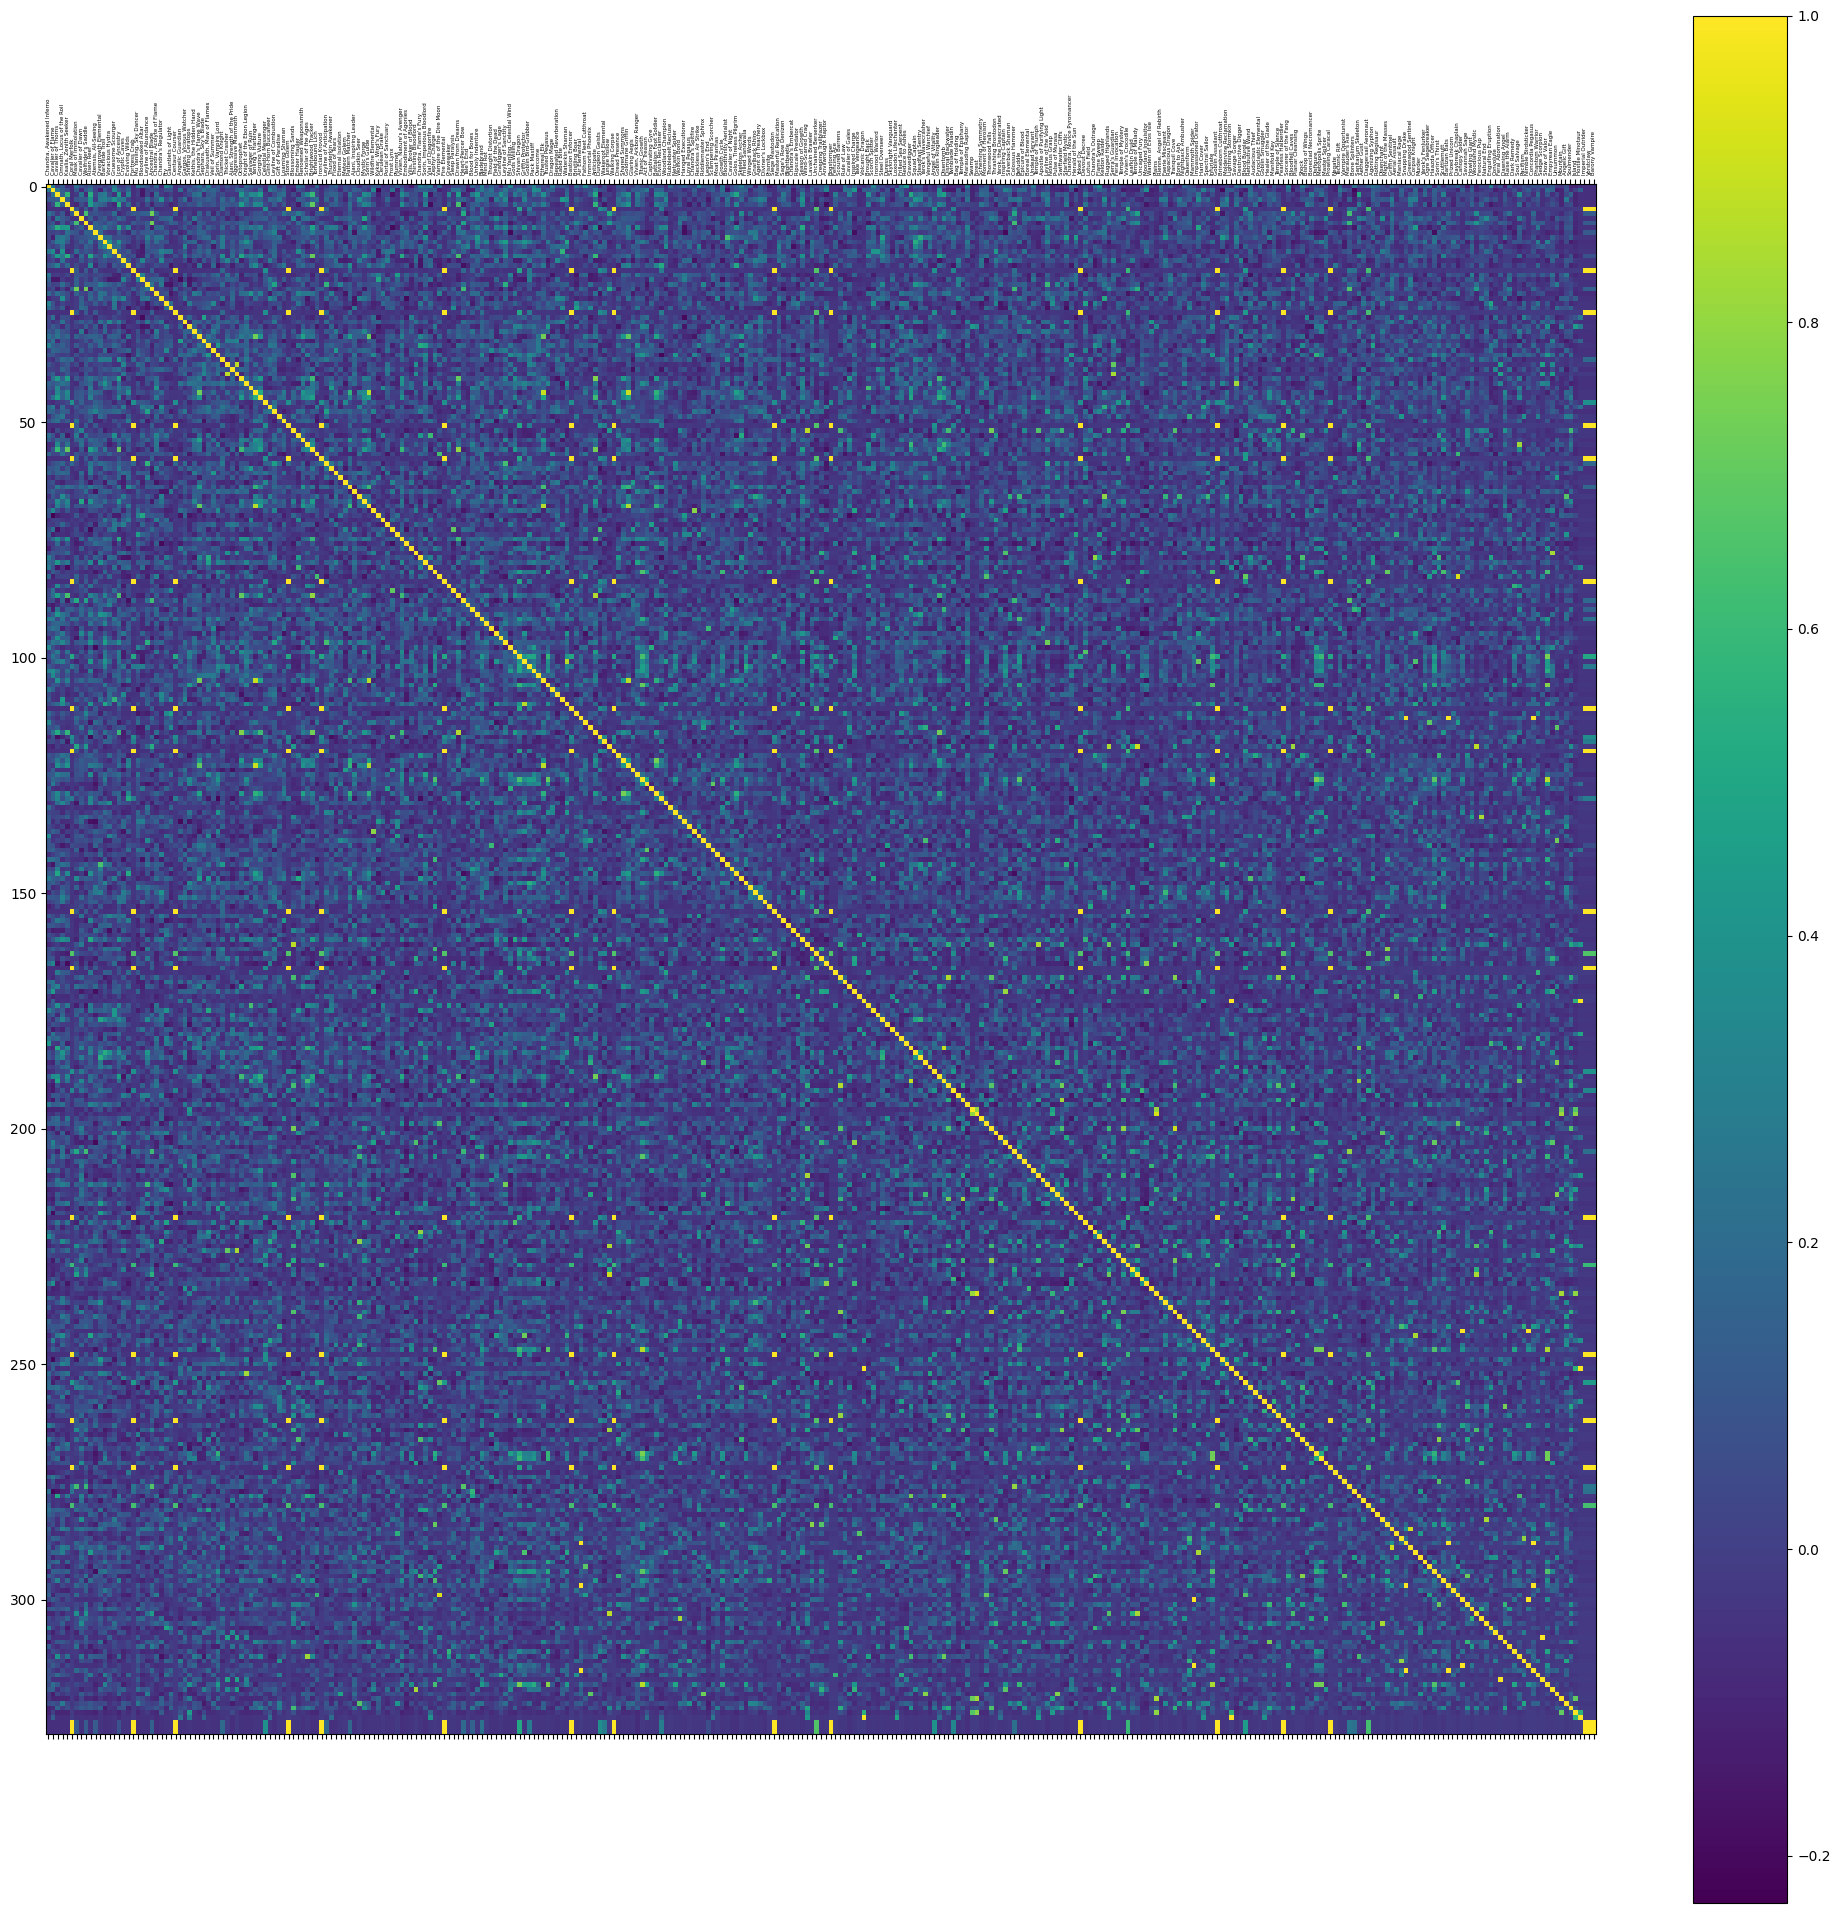

In [79]:
f, axes = plt.subplots(figsize=(25, 25), dpi=100)
c = axes.matshow(cos_similarity)
plt.xticks(ticks=range(329), labels=pd_number_names['name'].tolist(), rotation=90, fontsize=4)
plt.colorbar(c)

In [80]:
import bct

In [82]:
cos_similarity = np.abs(cos_similarity)

In [105]:
ca, Q = bct.community_louvain(1.0 / cos_similarity)

In [106]:
Q

0.5380548780281155

In [107]:
m = np.max(ca)

In [108]:
m

22

In [109]:
len(ca)

329

In [110]:
for i in range(1, m + 1):
    indices = np.where(ca == i)[0]
    group = pd_number_names.loc[indices]
    print(group.sort_values('name'))

     number                    name
286       1          Aerial Assault
264     242         Bloodfell Caves
137     132      Chandra's Spitfire
79      294   Chandra, Flame's Fury
253     134      Destructive Digger
62       15       Eternal Isolation
85      323              Gravewaker
250     214  Moldervine Reclamation
41       70             Octoprophet
109     190              Rabid Bite
182     155         Reduce to Ashes
198     113       Scheming Symmetry
163     164     Unchained Berserker
69      297      Wildfire Elemental
     number              name
12      165    Barkhide Troll
227     170  Feral Invocation
68      292     Sorin's Guide
     number                  name
52      243      Blossoming Sands
208      49      Boreal Elemental
121      96        Dread Presence
258     144       Goblin Smuggler
45      102       Gorging Vulture
14      104     Gruesome Scourger
203      25     Inspiring Captain
21      179  Leyline of Abundance
212     107   Leyline of the Void


In [72]:
# the graph clustering on the above!